In [1]:
from main import *
from visualization import *
from stats import *

from brainspace.gradient.embedding import DiffusionMaps, diffusion_mapping
from scipy.stats import spearmanr
from brainsmash.mapgen.base import Base

%matplotlib inline
plt.rcParams['font.size'] = 18

# Setting paths

In [2]:
top_directory = '/media/anleg84/Backup Plus/CERVO/Data/Networks2024/'
atlas_path = '/home/anleg84/Documents/Atlas/MapzebrainOld/'

atlas = MapzebrainAtlas(atlas_path)
excluded = np.load('Results/excluded_regions.npy')

centroids = np.concatenate([atlas.regionCentroids['left'], atlas.regionCentroids['right']], axis=0)
centroids[:, 1] = 974 - centroids[:, 1]
excluded = np.load('Results/excluded_regions.npy')
centroids = np.delete(centroids, np.concatenate([excluded, excluded + 70]), axis=0)
delete = delete_rows_and_columns

distances = delete(atlas.computeDistanceBetweenRegions(), excluded)

In [3]:
FC = np.load('Results/FC_matrix_truncated.npy')
SC = np.load('Results/undirected_terminals_expanded.npy')

# Loading region series

In [6]:
datasets = get_datasets(top_directory, ['920nm', 'wholebrain'])

Computing FC, with visual stimuli. Useful for later.

In [7]:
sigma = 2
rseries = []
for ds in datasets:
    rseries.append(np.load(ds + 'region_series_dff.npy')[:, :])
    for i in range(rseries[-1].shape[0]):
        rseries[-1][i] = gaussian_filter1d(rseries[-1][i], sigma)

matrices = []
for ts in rseries:
    matrix = compute_correlation_matrix(ts)
    #matrix[np.isnan(matrix)] = 0
    matrices.append(matrix)
matrices = np.stack(matrices, axis=0)

matrices = np.delete(matrices, excluded, axis=1)
matrices = np.delete(matrices, excluded, axis=2)

FC_stim = np.nanmean(matrices, axis=0)

In [8]:
np.save('Results/figure6_FC_stim.npy', FC_stim)

# Functional network gradients

In [9]:
with temp_random_state(0):
    modes_FC, eigvals_FC = diffusion_mapping(FC, n_components=65)
    #order = np.flip(np.argsort(np.abs(eigvals_FC)))
    modes_FC = modes_FC.T
    gradient1f = modes_FC[0]
    gradient2f = modes_FC[1]

/home/anleg84/anaconda3/envs/calimba/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1592: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


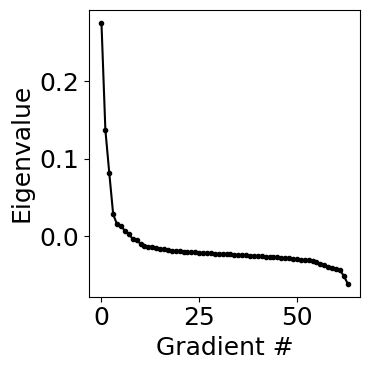

In [10]:
plt.figure(figsize=(4, 4))
plt.plot(eigvals_FC, marker='.', color='black')
plt.xlabel('Gradient #')
plt.ylabel('Eigenvalue')
plt.tight_layout(pad=1)

First gradient

0.4480330677675725


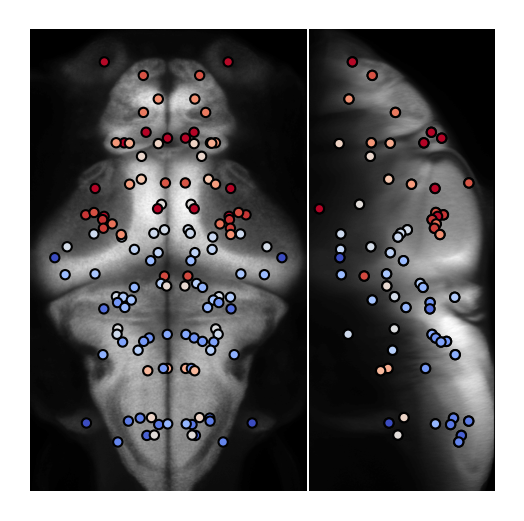

In [11]:
v = np.percentile(np.abs(modes_FC[0]), 90)
print(v)
plot_regional_values(modes_FC[0], atlas, excluded=excluded, double_vector=True, cmap='coolwarm', vmin=-v, vmax=v)
%matplotlib inline

Second gradient

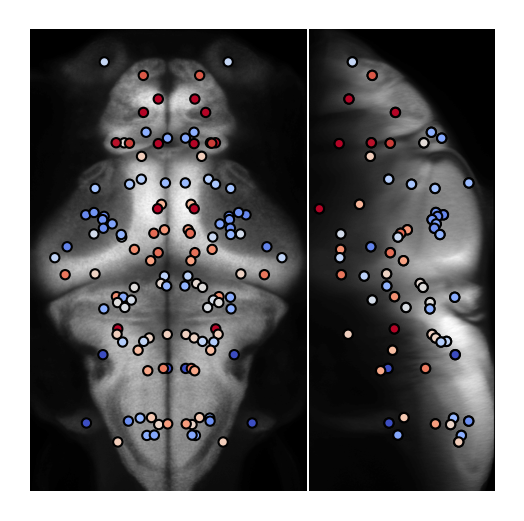

In [12]:
v = np.percentile(np.abs(modes_FC[1]), 90)
plot_regional_values(modes_FC[1], atlas, excluded=excluded, double_vector=True, cmap='coolwarm', vmin=-v, vmax=v)
%matplotlib inline

Third gradient

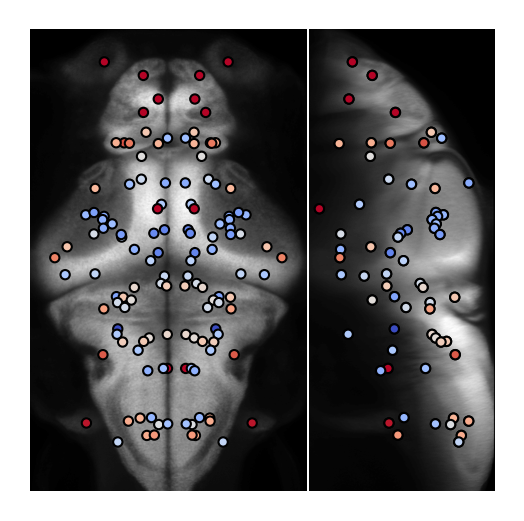

In [13]:
v = np.percentile(np.abs(modes_FC[2]), 90)
plot_regional_values(modes_FC[2], atlas, excluded=excluded, double_vector=True, cmap='coolwarm', vmin=-v, vmax=v)
%matplotlib inline

In [14]:
np.save('Results/figure6_gradients_functional.npy', modes_FC)
np.save('Results/figure6_eigenvalues_functional.npy', eigvals_FC)

# Structural network gradients

In [15]:
%matplotlib inline

In [16]:
with temp_random_state(0):

    modes_SC, eigvals_SC = diffusion_mapping(SC, n_components=70, alpha=0.5)
    modes_SC = np.delete(modes_SC, excluded, axis=0).T
    gradient1s = modes_SC[0]
    gradient2s = modes_SC[1]

/home/anleg84/anaconda3/envs/calimba/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1592: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


Text(0, 0.5, 'Eigenvalue')

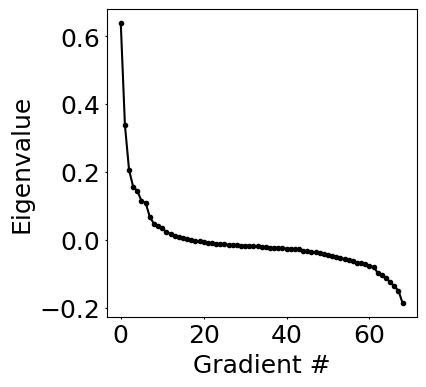

In [17]:
plt.figure(figsize=(4, 4))
plt.plot(eigvals_SC, marker='.', color='black')
plt.xlabel('Gradient #')
plt.ylabel('Eigenvalue')

First gradient

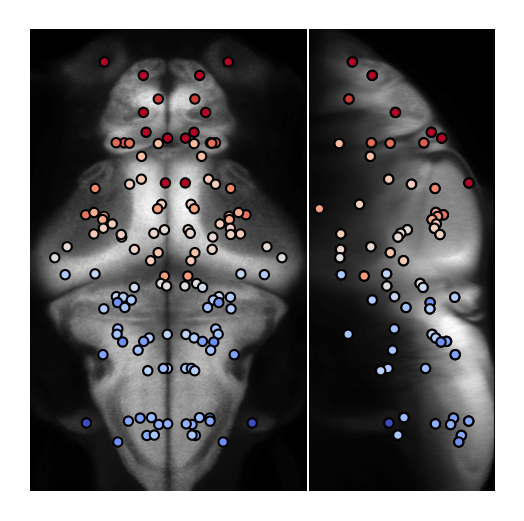

In [18]:
v = np.percentile(np.abs(modes_SC[0]), 90)
plot_regional_values(modes_SC[0], atlas, excluded=excluded, double_vector=True, cmap='coolwarm', vmin=-v, vmax=v)
%matplotlib inline

Second gradient

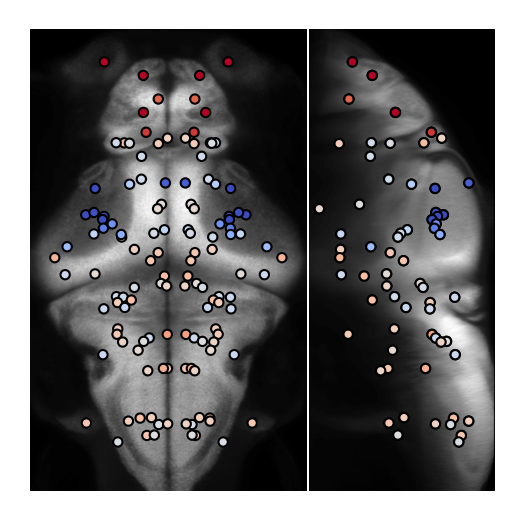

In [19]:
v = np.percentile(np.abs(modes_SC[1]), 90)
plot_regional_values(modes_SC[1], atlas, excluded=excluded, double_vector=True, cmap='coolwarm', vmin=-v, vmax=v)
%matplotlib inline

Third gradient

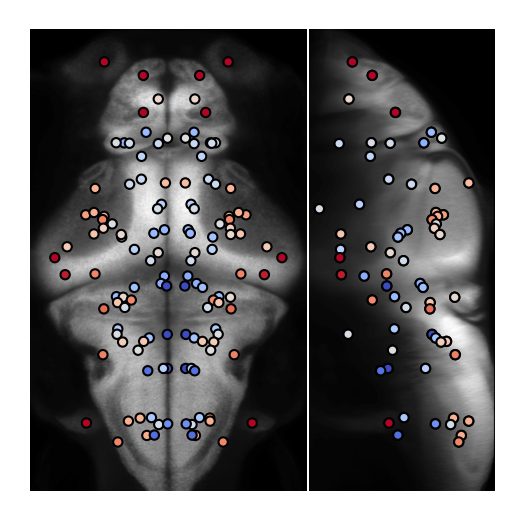

In [20]:
v = np.percentile(np.abs(modes_SC[2]), 90)
plot_regional_values(modes_SC[2], atlas, excluded=excluded, double_vector=True, cmap='coolwarm', vmin=-v, vmax=v)
%matplotlib inline

In [21]:
np.save('Results/figure6_gradients_structural.npy', modes_SC)
np.save('Results/figure6_eigenvalues_structural.npy', eigvals_SC)

# Similarity between functional/structural modes

In [ ]:
from scipy.optimize import linear_sum_assignment

def compute_mode_similarity_matrix(modes1, modes2, return_mapping=False, method='pearson'):
    N_modes = modes1.shape[0]
    corrs = np.zeros((N_modes, N_modes))
    for i in range(N_modes):
        for j in range(N_modes):
            if method == 'pearson':
                corrs[i, j] = pearsonr(modes1[i], modes2[j])[0]
            elif method == 'spearman':
                corrs[i, j] = spearmanr(modes1[i], modes2[j])[0]
    
    cost_matrix = 1 - np.abs(corrs)
    _, mapping = linear_sum_assignment(cost_matrix)
    
    corrs = np.zeros((N_modes, N_modes))
    for i in range(N_modes):
        for j in range(N_modes):
            if method == 'pearson':
                corrs[i, j] = pearsonr(modes1[i], modes2[mapping[j]])[0]
            elif method == 'spearman':
                corrs[i, j] = spearmanr(modes1[i], modes2[mapping[j]])[0]
    if return_mapping:
        return corrs, mapping
    else:
        return corrs

In [22]:
correlations, mapping = compute_mode_similarity_matrix(modes_SC[:50], modes_FC[:50], return_mapping=True, method='pearson')

In [23]:
mapping

array([ 0,  1,  3,  9, 14, 12,  5,  2,  6, 16, 18,  7, 13, 10, 29, 19, 24,
       47, 11,  4, 22, 21, 39, 30, 27, 28, 45, 32, 37, 41, 20, 15, 17, 25,
       38, 26, 33, 40, 31, 43, 34, 46, 23, 44, 42, 35, 48, 36, 49,  8])

In [26]:
correlations[2, 2]

-0.4656825770253053

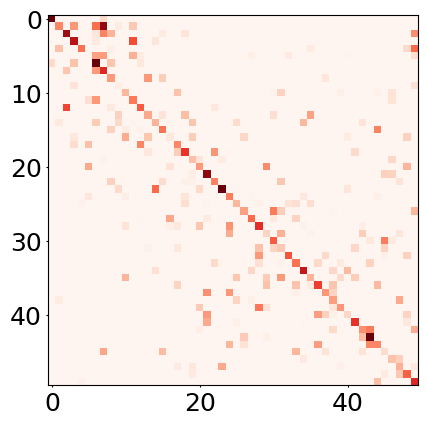

In [24]:
plt.imshow(np.abs(correlations), cmap='Reds', vmin=0.2, vmax=0.5)
#plt.xticks(np.arange(20), np.arange(20) + 1)
#plt.yticks(np.arange(20), mapping[:20] + 1)
plt.show()

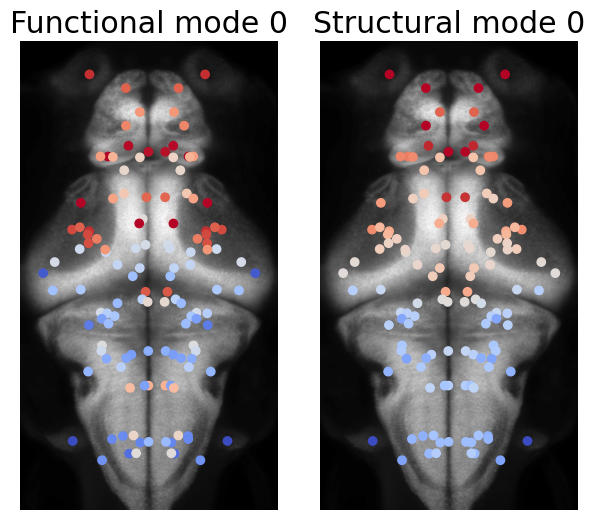

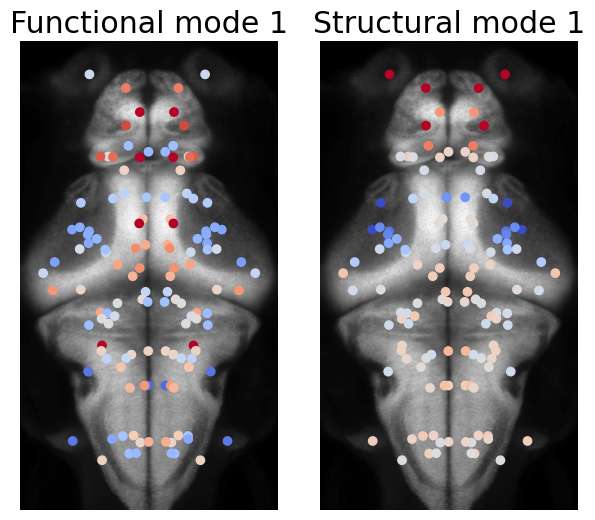

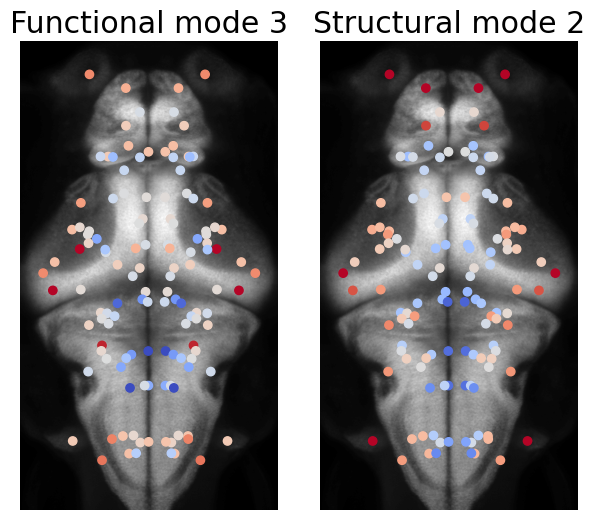

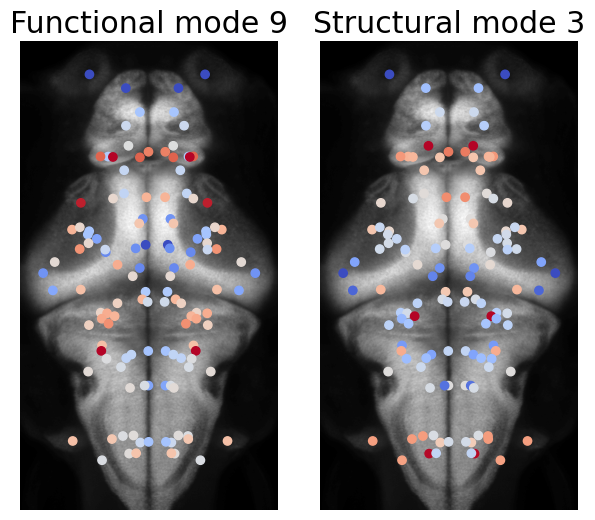

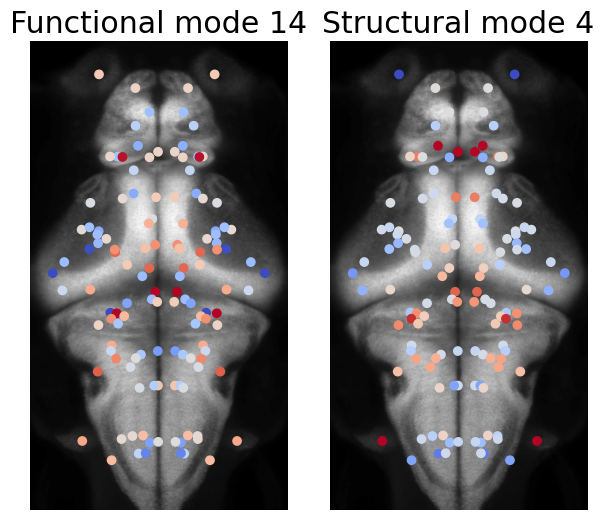

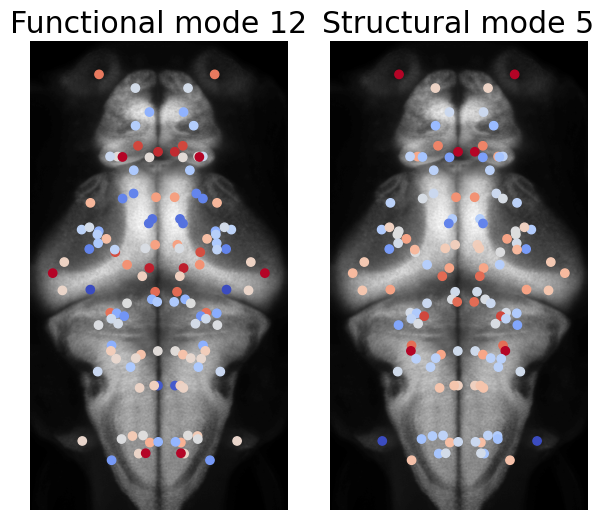

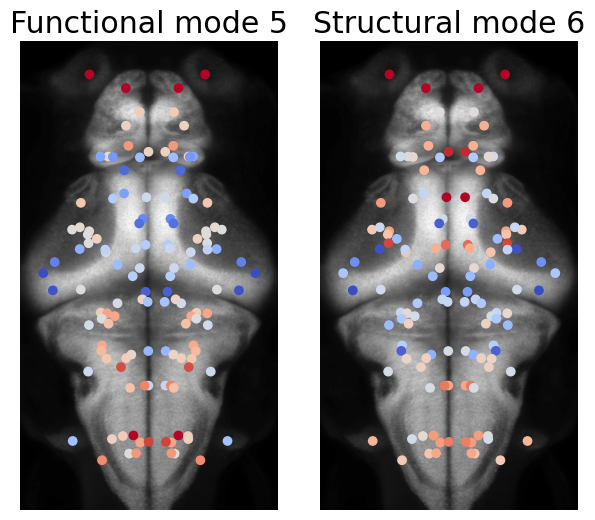

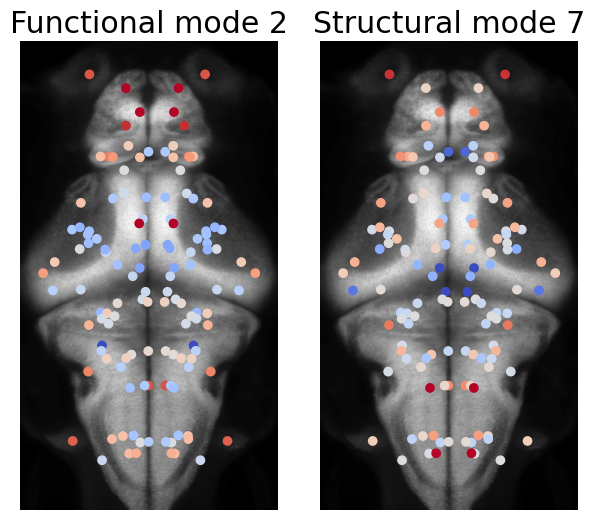

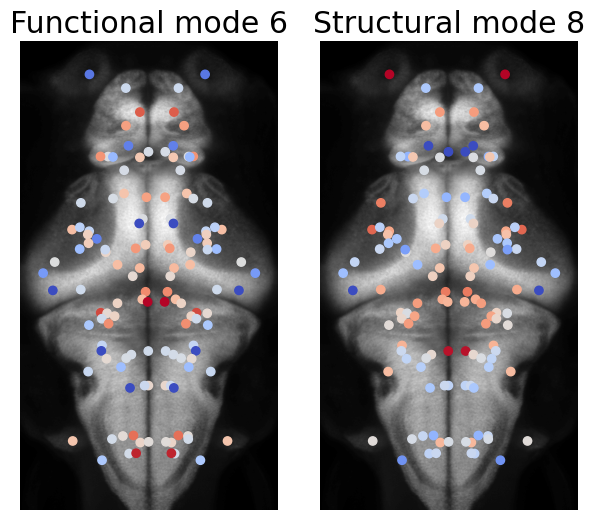

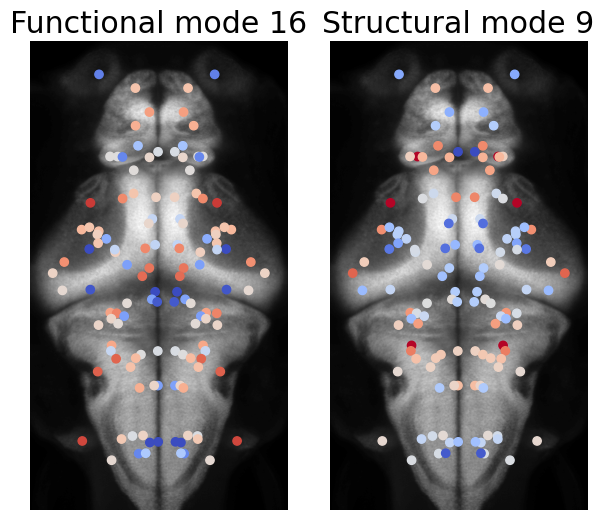

In [23]:
for i in range(10):

    fig, ax = plt.subplots(1, 2, figsize=(6, 5))
    sign = np.sign(correlations[i, i])
    
    v = np.percentile(np.abs(modes_FC[mapping[i]]), 95)
    ax[0].imshow(atlas.XYprojection, cmap='gray')
    ax[0].scatter(centroids[:, 0], centroids[:, 1], c=sign * double(modes_FC[mapping[i]]), cmap='coolwarm', vmin=-v, vmax=v)
    ax[0].set_xlim([65, 505])
    ax[0].set_ylim([850, 50])
    ax[0].axis('off')
    ax[0].set_title('Functional mode {}'.format(mapping[i]))
    
    v = np.percentile(np.abs(modes_SC[i]), 95)
    ax[1].imshow(atlas.XYprojection, cmap='gray')
    ax[1].scatter(centroids[:, 0], centroids[:, 1], c=double(modes_SC[i]), cmap='coolwarm', vmin=-v, vmax=v)
    ax[1].set_xlim([65, 505])
    ax[1].set_ylim([850, 50])
    ax[1].axis('off')
    ax[1].set_title('Structural mode {}'.format(i))
    
    plt.tight_layout(pad=0)

In [24]:
np.save('Results/figure6_correlations_modes.npy', correlations)
np.save('Results/figure6_mapping_modes.npy', mapping)

# Significance of SC-FC gradients correlation

In this part, we evaluate the significance of the correlations between SC and FC gradients.

#### 1. Comparing functional gradients with SCCM gradients

Significance of average gradient correlation.

In [41]:
#SC_SCCM = np.load('Results/null_SC_expanded_deltaD_30.npy')
SC_SCCM = np.load('Results/null_SC_und_SCCM.npy')

corrs_null_all = []
for S in tqdm(SC_SCCM, file=sys.stdout):
    modes_SCCM, _ = diffusion_mapping(S, n_components=70, alpha=0.5)
    modes_SCCM = np.delete(modes_SCCM, excluded, axis=0).T
    corrs_null = compute_mode_similarity_matrix(modes_SCCM[:50], modes_FC[:50], method='pearson')
    corrs_null_all.append(np.diag(corrs_null))
corrs_null_all = np.array(corrs_null_all)

100%|███████████████████████████████████████| 1000/1000 [03:35<00:00,  4.63it/s]


Average across all modes

In [26]:
corrs_empirical = np.mean(np.abs(np.diag(correlations)[:]))
null_distribution = np.mean(np.abs(corrs_null_all[:, :]), axis=1)

In [27]:
np.mean(null_distribution)

0.30830771695605125

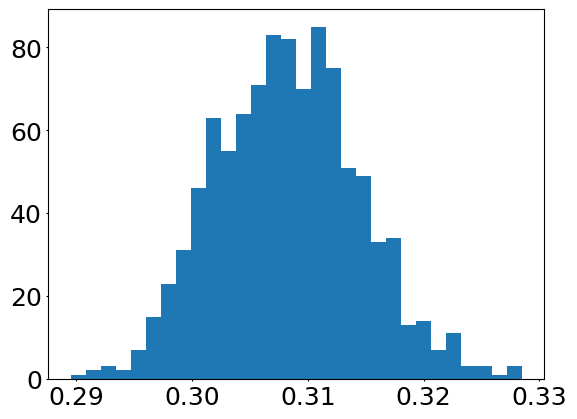

Empirical value: 0.34875313878350167


In [28]:
plt.hist(null_distribution, bins=30)
plt.show()
print('Empirical value:', corrs_empirical)

In [29]:
percentileofscore(null_distribution, corrs_empirical)

100.0

Mode similarity matrix diagonals generated using SCCM gradients are significantly lower than empirical mode correlations (percentile 100, thus $P=0$).

#### Mode-to-mode significance

In [53]:
P_values_SCCM = []

for i in range(50):
    corr_empirical = np.abs(np.diag(correlations))[i]
    null_distribution = np.abs(corrs_null_all)[:, i]
    perc = percentileofscore(null_distribution, corr_empirical)
    P_values_SCCM.append((100 - perc) / 100)

P_values_SCCM = np.array(P_values_SCCM)

In [60]:
P_values_SCCM

array([0.   , 0.936, 0.056, 0.08 , 0.297, 0.928, 0.   , 0.075, 0.419,
       0.934, 0.592, 0.261, 0.149, 0.511, 0.577, 0.23 , 0.897, 0.335,
       0.065, 0.677, 0.451, 0.006, 0.309, 0.001, 0.335, 0.622, 0.506,
       0.22 , 0.068, 0.844, 0.177, 0.757, 0.154, 0.319, 0.036, 0.654,
       0.097, 0.468, 0.54 , 0.474, 0.842, 0.064, 0.416, 0.   , 0.321,
       0.859, 0.731, 0.615, 0.156, 0.036])

In [54]:
np.sum(P_values_SCCM < 0.05)

7

At the single-mode level, 7 mode pairs are significantly correlated ($P<0.05$).

#### 2. Spatially shuffling gradients

Now, instead of comparing with null SCCM gradients, we spatially shuffle them using BrainSMASH.

Correlations across all modes

In [25]:
corrs_null_all = []

for _ in tqdm(range(1000), file=sys.stdout):
    surrogate_modes = []
    for m in modes_FC[:50]:
        base = Base(x=m, D=distances, resample=True)
        surrogate = base(n=1)
        surrogate_modes.append(surrogate)
    surrogate_modes = np.stack(surrogate_modes, axis=0)
    corrs_null = compute_mode_similarity_matrix(modes_SC[:50], surrogate_modes, method='pearson')
    corrs_null_all.append(np.diag(corrs_null))
    
corrs_null_all = np.array(corrs_null_all)

100%|███████████████████████████████████████| 1000/1000 [24:56<00:00,  1.50s/it]


In [29]:
corrs_empirical = np.mean(np.abs(np.diag(correlations))[:50])
null_distribution = np.mean(np.abs(corrs_null_all), axis=1)

In [30]:
percentileofscore(null_distribution, corrs_empirical)

100.0

First mode only

In [30]:
corrs_null_first = []

for _ in tqdm(range(1000), file=sys.stdout):
    base = Base(x=modes_FC[0], D=distances, resample=True)
    surrogate = base(n=1)
    r = pearsonr(surrogate, modes_SC[0])[0]
    corrs_null_first.append(r)

100%|███████████████████████████████████████| 1000/1000 [00:51<00:00, 19.51it/s]


In [31]:
corr_empirical = np.abs(correlations[0, 0])
null_distribution = np.abs(corrs_null_first)

In [32]:
percentileofscore(null_distribution, corr_empirical)

98.1

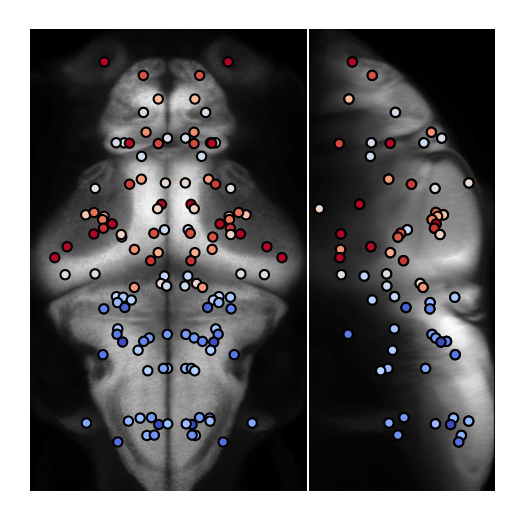

In [33]:
v = np.percentile(np.abs(surrogate), 90)
plot_regional_values(surrogate, atlas, excluded=excluded, double_vector=True, cmap='coolwarm', vmin=-v, vmax=v)
%matplotlib inline

Second mode only

In [34]:
corrs_null_first = []

for _ in tqdm(range(1000), file=sys.stdout):
    base = Base(x=modes_FC[1], D=distances, resample=True)
    surrogate = base(n=1)
    r = pearsonr(surrogate, modes_SC[1])[0]
    corrs_null_first.append(r)

100%|███████████████████████████████████████| 1000/1000 [00:48<00:00, 20.46it/s]


In [35]:
corr_empirical = np.abs(correlations[1, 1])
null_distribution = np.abs(corrs_null_first)

In [36]:
percentileofscore(null_distribution, corr_empirical)

89.9

#### Spatial shuffling of matched modes to estimate significance

In [37]:
corrs_null_singlemodes = []

for i in tqdm(range(50)):

    corrs_null_ = []

    for _ in range(1000):
        base = Base(x=modes_FC[mapping[i]], D=distances, resample=True)
        surrogate = base(n=1)
        r = pearsonr(surrogate, modes_SC[i])[0]
        corrs_null_.append(r)

    corrs_null_singlemodes.append(corrs_null_)

100%|███████████████████████████████████████████| 50/50 [23:56<00:00, 28.72s/it]


Computing P-values

In [38]:
P_values = []

for i in range(50):
    corr_empirical = np.abs(correlations[i, i])
    null_distribution = np.abs(corrs_null_singlemodes[i])
    perc = percentileofscore(null_distribution, corr_empirical)
    P_values.append((100 - perc) / 100)

P_values = np.array(P_values)

In [40]:
P_values

array([0.025, 0.073, 0.002, 0.   , 0.004, 0.129, 0.   , 0.006, 0.016,
       0.064, 0.017, 0.001, 0.   , 0.006, 0.015, 0.004, 0.064, 0.005,
       0.   , 0.007, 0.007, 0.   , 0.003, 0.   , 0.006, 0.012, 0.011,
       0.002, 0.   , 0.022, 0.001, 0.022, 0.001, 0.001, 0.   , 0.014,
       0.   , 0.011, 0.005, 0.007, 0.031, 0.   , 0.001, 0.   , 0.005,
       0.029, 0.016, 0.009, 0.   , 0.001])

In [39]:
np.sum(P_values < 0.05)

46

#### Intersection of both criteria

In [59]:
np.where((P_values < 0.05) & (P_values_SCCM < 0.05))

(array([ 0,  6, 21, 23, 34, 43, 49]),)

7 gradient pairs are significantly correlated in both statistical tests. Most importantly, this includes the first anteroposterior SC-FC gradient.

# Computing sensorimotor index per brain region

Now we establish the proportions of visual and motor cells per brain region.

In [40]:
N_neurons_per_region = np.load('Results/N_neurons_per_region.npy')

In [226]:
corrs_per_region_dark, cells_per_region_dark = [], []
corrs_per_region_motor, cells_per_region_motor = [], []

for folder in tqdm(datasets, file=sys.stdout):

    if 'correlated_motor.npy' in identify_files(folder, ['.npy']):

        coprd, ceprd = [], []
        coprm, ceprm = [], []
        
        data = load_data(folder)
        corrs_dark = np.load(folder + 'correlations_dark.npy')
        corrs_motor = np.load(folder + 'correlations_motor.npy')
        cells_dark = np.load(folder + 'correlated_dark.npy')
        cells_motor = np.load(folder + 'correlated_motor.npy')
        regions = data['region_labels']
    
        for i in range(regions.shape[1]):
            in_region = regions[:, i] > 0
            coprd.append(np.mean(corrs_dark[in_region]))
            ceprd.append(np.sum(cells_dark[in_region]))
            coprm.append(np.mean(corrs_motor[in_region]))
            ceprm.append(np.sum(cells_motor[in_region]))

    corrs_per_region_dark.append(coprd)
    cells_per_region_dark.append(ceprd)
    corrs_per_region_motor.append(coprm)
    cells_per_region_motor.append(ceprm)

corrs_per_region_dark = np.stack(corrs_per_region_dark)
cells_per_region_dark = np.stack(cells_per_region_dark)
corrs_per_region_motor = np.stack(corrs_per_region_motor)
cells_per_region_motor = np.stack(cells_per_region_motor)

corrs_per_region_dark[np.isnan(corrs_per_region_dark)] = 0
corrs_per_region_motor[np.isnan(corrs_per_region_motor)] = 0

  5%|██                                          | 1/22 [00:05<01:46,  5.06s/it]

/home/anleg84/anaconda3/envs/calimba/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/anleg84/anaconda3/envs/calimba/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


100%|███████████████████████████████████████████| 22/22 [01:39<00:00,  4.53s/it]


In [227]:
fraction_dark = np.mean(cells_per_region_dark, axis=0) / (np.mean(N_neurons_per_region, axis=0) + 1)
fraction_motor = np.mean(cells_per_region_motor, axis=0) / (np.mean(N_neurons_per_region, axis=0) + 1)
corrs_dark = np.mean(corrs_per_region_dark, axis=0)
corrs_motor = np.mean(corrs_per_region_motor, axis=0)

In [228]:
score_visual = fraction_dark
score_visual = np.delete(score_visual, excluded)
score_motor = fraction_motor
score_motor = np.delete(score_motor, excluded)

In [229]:
sensorimotor_index = score_visual - score_motor

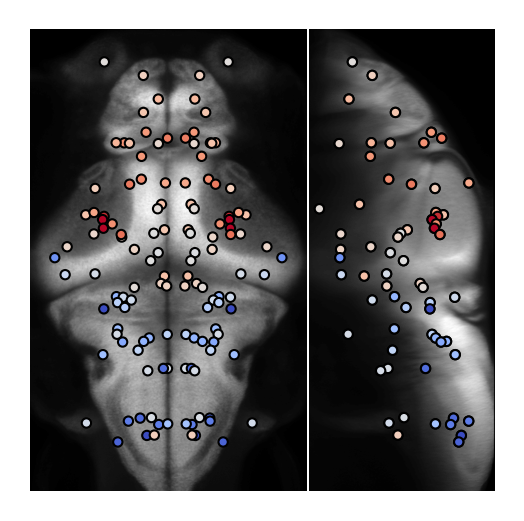

In [230]:
v = np.percentile(np.abs(sensorimotor_index), 95)
plot_regional_values(sensorimotor_index, atlas, excluded=excluded, double_vector=True, cmap='coolwarm', vmin=-v, vmax=v)
%matplotlib inline

In [231]:
np.save('Results/figure6_sensorimotor_index.npy', sensorimotor_index)

# Comparing gradients with sensorimotor index

Correlating the SI with the first FC gradient.

In [172]:
sensorimotor_index = np.load('Results/figure6_sensorimotor_index.npy')

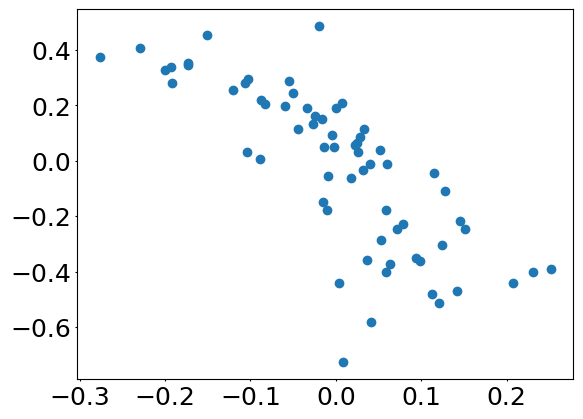

In [173]:
plt.scatter(sensorimotor_index, -modes_FC[0])

In [174]:
r_sensorimotor_functional = np.abs(spearmanr(sensorimotor_index, modes_FC[0])[0])
print(r_sensorimotor_functional)

0.8319493006993007


Correlating the SI with the first SC gradient.

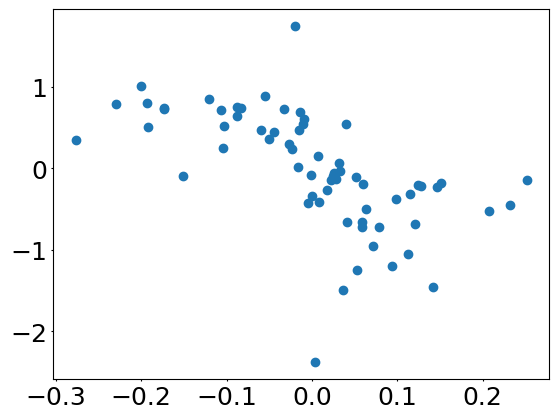

In [175]:
plt.scatter(sensorimotor_index, modes_SC[0])

In [186]:
r_sensorimotor_structural = np.abs(spearmanr(sensorimotor_index, modes_SC[0])[0])
print(r_sensorimotor_structural)

0.7792832167832168


#### Spatial shuffling of the sensorimotor index

Functional

In [180]:
corrs_null = []

for _ in tqdm(range(1000), file=sys.stdout):
    base = Base(x=sensorimotor_index, D=distances, resample=True)
    surrogate = base(n=1)
    r = spearmanr(surrogate, modes_FC[0])[0]
    corrs_null.append(np.abs(r))

100%|███████████████████████████████████████| 1000/1000 [00:32<00:00, 31.09it/s]


In [181]:
percentileofscore(corrs_null, r_sensorimotor_functional)

100.0

Structural

In [182]:
corrs_null = []

for _ in tqdm(range(1000), file=sys.stdout):
    base = Base(x=sensorimotor_index, D=distances, resample=True)
    surrogate = base(n=1)
    r = spearmanr(surrogate, modes_SC[0])[0]
    corrs_null.append(np.abs(r))

100%|███████████████████████████████████████| 1000/1000 [00:33<00:00, 30.19it/s]


In [183]:
percentileofscore(corrs_null, r_sensorimotor_structural)

93.1

# High-resolution gradient

Now we subdivide the brain into ~1000 nodes to compute a high-resolution sensorimotor index and compare it with high-resolution gradients.

In [55]:
from sklearn.cluster import KMeans

In [56]:
volumes = np.copy(atlas.relativeVolumes)
volumes[10] = 0
volumes /= np.sum(volumes)

In [61]:
N_clusters_per_region = ((volumes * 1035) + 1).astype('int')
N_clusters_per_region[N_clusters_per_region > 1] -= 1

In [62]:
np.sum(N_clusters_per_region)

1001

In [46]:
region_centroids = []
region_labels = []

for r in tqdm(range(70), file=sys.stdout):
    N_clusters = N_clusters_per_region[r]
    mask = atlas.getRegionMask(r)[:, :, :284]
    mask = zoom(mask, (0.25, 0.25, 0.25), order=0)
    i, j, k = np.where(mask)
    centroids = np.stack([i, j, k], axis=1)
    kmeans = KMeans(n_clusters=N_clusters).fit(centroids)
    clusters = kmeans.labels_
    cluster_centroids = kmeans.cluster_centers_
    
    region_centroids.append(cluster_centroids)
    region_labels += [r] * N_clusters

# Reflecting on other hemisphere
region_centroids_left = np.concatenate(region_centroids, axis=0)
region_centroids_left = np.flip(region_centroids_left, axis=1) * 4
region_centroids_right = np.copy(region_centroids_left)
region_centroids_right[:, 0] = - (region_centroids_right[:, 0] - 284) + 284
region_centroids = np.concatenate([region_centroids_left, region_centroids_right], axis=0)
region_labels = np.array(region_labels + region_labels)

100%|███████████████████████████████████████████| 70/70 [01:59<00:00,  1.70s/it]


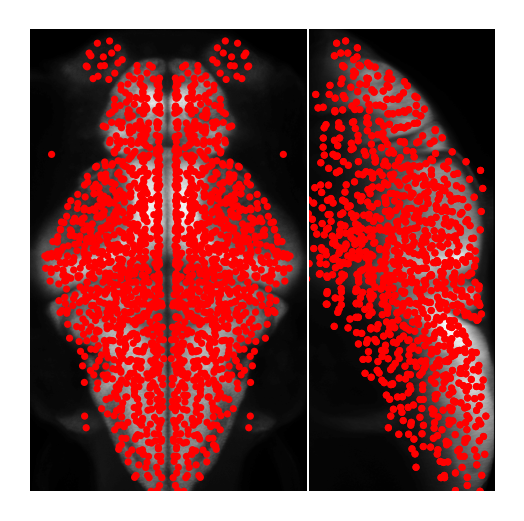

In [69]:
plot_centroids_on_atlas(region_centroids, atlas, alpha=1)
%matplotlib inline

In [48]:
np.save('Results/region_centroids_highres.npy', region_centroids)
np.save('Results/region_labels_highres.npy', region_labels)

# Hi-res sensorimotor gradient correlation - Spontaneous

Comparing the sensorimotor index with spontaneous FC in the high-res parcellation.

In [145]:
import warnings

In [146]:
region_centroids_hires = np.load('Results/region_centroids_highres.npy')
region_labels_hires = np.load('Results/region_labels_highres.npy')

In [147]:
from sklearn.neighbors import NearestNeighbors

def find_nearest_neighbors(centroids1, centroids2):
    nn_model = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(centroids2)
    _, indices = nn_model.kneighbors(centroids1)
    return indices.flatten()

In [148]:
N_regions = int(len(region_labels_hires) / 2)

In [149]:
with warnings.catch_warnings():
    
    warnings.simplefilter("ignore")

    matrices = []
    N_neurons_all = []
    N_dark_all = []
    N_motor_all = []
    
    for folder in tqdm(datasets, file=sys.stdout):

        if any(identify_files(folder, ['motor.npy'])):
    
            region_series = np.zeros
                
            data = load_data(folder)
            region_labels = data['region_labels']
            region_labels[:, 10] = 0
            in_brain = np.sum(region_labels, axis=1) > 0
            centroids = data['centroids_atlas'][in_brain]
            cells_dark = np.load(folder + 'correlated_dark.npy')[in_brain]
            cells_motor = np.load(folder + 'correlated_motor.npy')[in_brain]
            dff = np.load(folder + 'dff.npy')[in_brain][:, :600] # Selecting first 10 minutes without stimulation
        
            NN = find_nearest_neighbors(centroids, region_centroids_hires)
    
            N_neurons, N_dark, N_motor = [], [], []
            region_series = np.zeros((N_regions * 2, dff.shape[1]))
            for i in range(N_regions * 2):
                c = centroids[NN == i]
                if np.any(c):
                    region_series[i] = gaussian_filter1d(np.mean(dff[NN == i], axis=0), 2)
                    N_neurons.append(c.shape[0])t
                    N_dark.append(np.sum(cells_dark[NN == i]))
                    N_motor.append(np.sum(cells_motor[NN == i]))
                else:
                    N_neurons.append(0)
                    N_dark.append(0)
                    N_motor.append(0)
                    
            N_neurons_all.append(N_neurons)
            N_dark_all.append(N_dark)
            N_motor_all.append(N_motor)
                    
            region_series = 0.5 * (region_series[:N_regions] + region_series[N_regions:])
            matrix = np.corrcoef(region_series)
            matrices.append(matrix)

100%|███████████████████████████████████████████| 22/22 [03:04<00:00,  8.40s/it]


In [150]:
N_neurons = np.mean(np.stack(N_neurons_all), axis=0)
N_neurons = 0.5 * (N_neurons[:N_regions] + N_neurons[N_regions:])

N_dark = np.mean(np.stack(N_dark_all), axis=0)
N_dark = 0.5 * (N_dark[:N_regions] + N_dark[N_regions:])

N_motor = np.mean(np.stack(N_motor_all), axis=0)
N_motor = 0.5 * (N_motor[:N_regions] + N_motor[N_regions:])

In [151]:
fraction_dark = N_dark / (N_neurons + 1)
fraction_motor = N_motor / (N_neurons + 1)

In [152]:
sensorimotor_index = fraction_dark - fraction_motor

In [153]:
FC_hi = np.nanmean(np.stack(matrices), axis=0)
FC_hi[np.isnan(FC_hi)] = 0
#FC_hi = np.abs(FC_hi)

/tmp/ipykernel_7263/2337416533.py:1: RuntimeWarning: Mean of empty slice
  FC_hi = np.nanmean(np.stack(matrices), axis=0)


In [154]:
excluded_hi = np.where(np.sum(FC_hi, axis=0) == 0)[0]

In [155]:
FC_hi_ = np.delete(np.delete(FC_hi, excluded_hi, axis=0), excluded_hi, axis=1)
FC_hi_[np.diag_indices(FC_hi_.shape[0])] = 0
#FC_hi_[FC_hi_ < 0] = 0

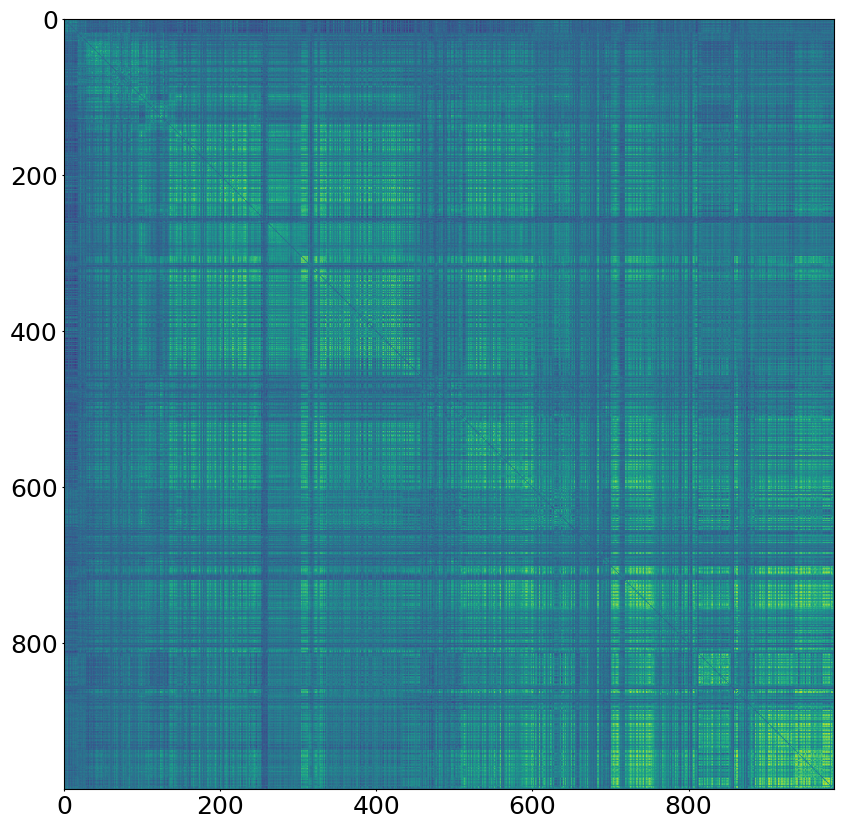

In [156]:
plt.figure(figsize=(10, 10))
plt.imshow(FC_hi_)

In [248]:
#with temp_random_state(42):
map = DiffusionMaps(n_components=10, alpha=0.5, random_state=420)
embedding = map.fit_transform(np.abs(FC_hi_))
gradient1f_hi = embedding[:, 0].flatten()
gradient2f_hi = embedding[:, 1].flatten()

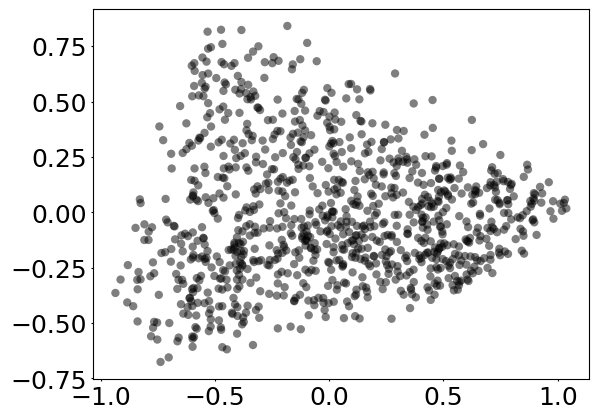

In [249]:
plt.scatter(gradient1f_hi, gradient2f_hi, color='black', alpha=0.5, edgecolor='None')

In [250]:
e = np.concatenate([excluded_hi, excluded_hi + N_regions])
c = np.delete(region_centroids_hires, e, axis=0)

(-0.5, 596.5, 973.5, -0.5)

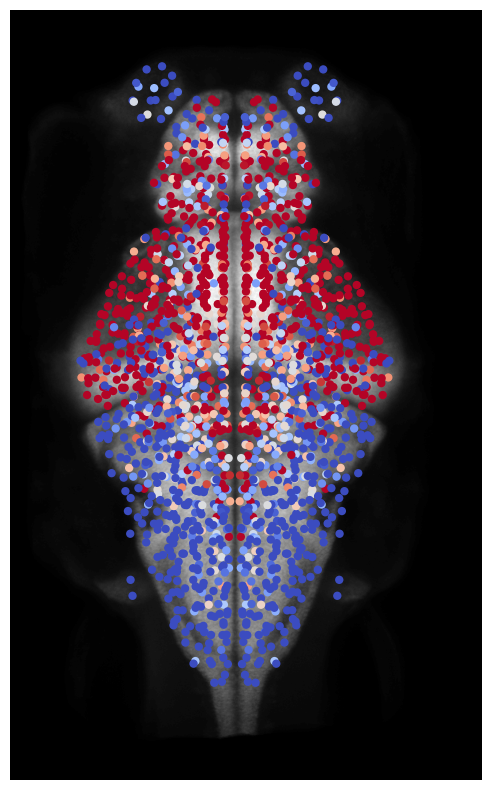

In [251]:
plt.figure(figsize=(10, 10))
plt.imshow(atlas.XYprojection, cmap='gray')
plt.scatter(c[:, 0], c[:, 1], edgecolor='None', c=double(embedding[:, 0].flatten()), cmap='coolwarm', vmin=-0.25, vmax=0.25)
plt.axis('off')

(-0.5, 973.5, 358.5, -0.5)

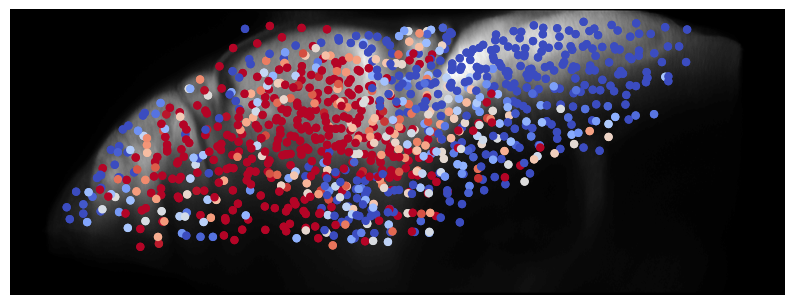

In [252]:
plt.figure(figsize=(10, 10))
plt.imshow(atlas.XZprojection, cmap='gray')
plt.scatter(c[:, 1], c[:, 2], edgecolor='None', c=double(embedding[:, 0].flatten()), cmap='coolwarm', vmin=-0.25, vmax=0.25)
plt.axis('off')

(-0.5, 596.5, 973.5, -0.5)

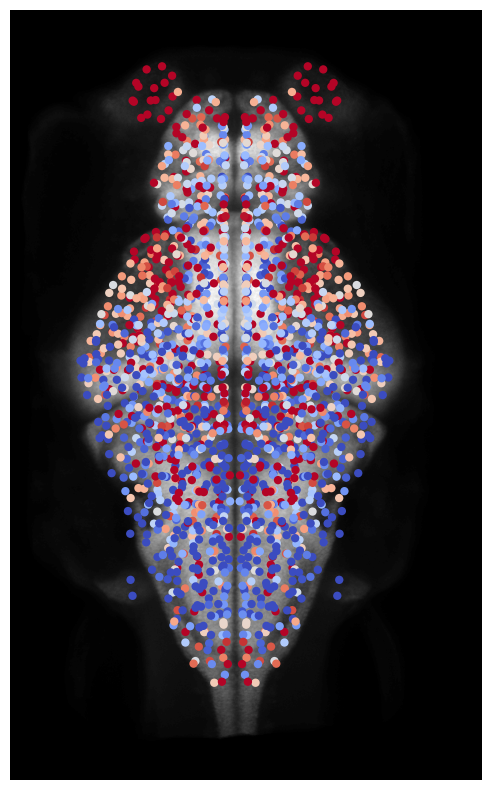

In [253]:
plt.figure(figsize=(10, 10))
plt.imshow(atlas.XYprojection, cmap='gray')
plt.scatter(c[:, 0], c[:, 1], edgecolor='None', c=double(embedding[:, 1].flatten()), cmap='coolwarm', vmin=-0.25, vmax=0.25)
plt.axis('off')

(-0.5, 973.5, 358.5, -0.5)

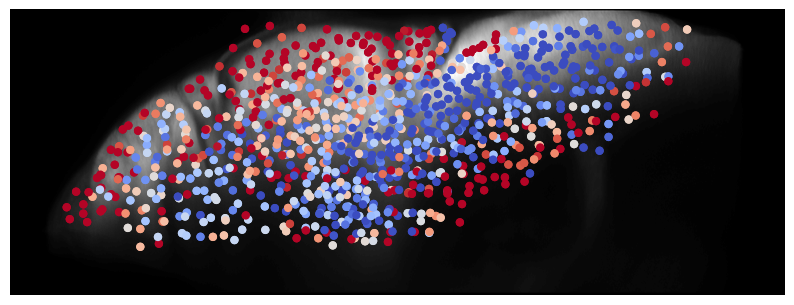

In [254]:
plt.figure(figsize=(10, 10))
plt.imshow(atlas.XZprojection, cmap='gray')
plt.scatter(c[:, 1], c[:, 2], edgecolor='None', c=double(embedding[:, 1].flatten()), cmap='coolwarm', vmin=-0.25, vmax=0.25)
plt.axis('off')

In [255]:
s = np.delete(sensorimotor_index, excluded_hi)

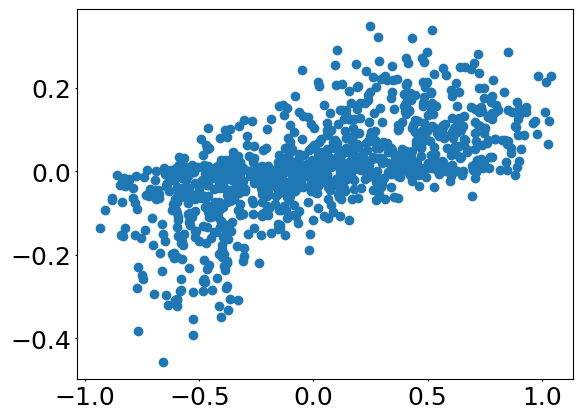

In [256]:
plt.scatter(gradient1f_hi, s)

In [257]:
from scipy.stats import spearmanr
spearmanr(gradient1f_hi, s)

SpearmanrResult(correlation=0.6645145546125301, pvalue=9.130262069028286e-127)

In [258]:
np.save('Results/figure6_FC_hires_spontaneous.npy', FC_hi_)
np.save('Results/figure6_sensorimotor_index_hires.npy', np.delete(sensorimotor_index, excluded_hi))
np.save('Results/figure6_centroids_hires.npy', c)

np.save('centroids_hires.npy', c)
np.save('gradient1.npy', double(gradient1f_hi))
np.save('gradient2.npy', double(gradient2f_hi))

# Hi-res sensorimotor gradient correlation - Visual stimulation

Comparing the sensorimotor index with visually stimulated FC in the high-res parcellation.

In [259]:
import warnings

In [260]:
region_centroids_hires = np.load('Results/region_centroids_highres.npy')
region_labels_hires = np.load('Results/region_labels_highres.npy')

In [261]:
from sklearn.neighbors import NearestNeighbors

def find_nearest_neighbors(centroids1, centroids2):
    nn_model = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(centroids2)
    _, indices = nn_model.kneighbors(centroids1)
    return indices.flatten()

In [262]:
N_regions = int(len(region_labels_hires) / 2)

In [263]:
with warnings.catch_warnings():
    
    warnings.simplefilter("ignore")

    matrices = []
    N_neurons_all = []
    N_dark_all = []
    N_motor_all = []
    
    for folder in tqdm(datasets, file=sys.stdout):

        if any(identify_files(folder, ['motor.npy'])):
    
            region_series = np.zeros
                
            data = load_data(folder)
            region_labels = data['region_labels']
            region_labels[:, 10] = 0
            in_brain = np.sum(region_labels, axis=1) > 0
            centroids = data['centroids_atlas'][in_brain]
            cells_dark = np.load(folder + 'correlated_dark.npy')[in_brain]
            cells_motor = np.load(folder + 'correlated_motor.npy')[in_brain]
            dff = np.load(folder + 'dff.npy')[in_brain][:, :] # Selecting full sequence with visual stimulation
        
            NN = find_nearest_neighbors(centroids, region_centroids_hires)
    
            N_neurons, N_dark, N_motor = [], [], []
            region_series = np.zeros((N_regions * 2, dff.shape[1]))
            for i in range(N_regions * 2):
                c = centroids[NN == i]
                if np.any(c):
                    region_series[i] = gaussian_filter1d(np.mean(dff[NN == i], axis=0), 2)
                    N_neurons.append(c.shape[0])
                    N_dark.append(np.sum(cells_dark[NN == i]))
                    N_motor.append(np.sum(cells_motor[NN == i]))
                else:
                    N_neurons.append(0)
                    N_dark.append(0)
                    N_motor.append(0)
                    
            N_neurons_all.append(N_neurons)
            N_dark_all.append(N_dark)
            N_motor_all.append(N_motor)
                    
            region_series = 0.5 * (region_series[:N_regions] + region_series[N_regions:])
            matrix = np.corrcoef(region_series)
            matrices.append(matrix)

100%|███████████████████████████████████████████| 22/22 [02:56<00:00,  8.04s/it]


In [264]:
N_neurons = np.mean(np.stack(N_neurons_all), axis=0)
N_neurons = 0.5 * (N_neurons[:N_regions] + N_neurons[N_regions:])

N_dark = np.mean(np.stack(N_dark_all), axis=0)
N_dark = 0.5 * (N_dark[:N_regions] + N_dark[N_regions:])

N_motor = np.mean(np.stack(N_motor_all), axis=0)
N_motor = 0.5 * (N_motor[:N_regions] + N_motor[N_regions:])

In [265]:
fraction_dark = N_dark / (N_neurons + 1)
fraction_motor = N_motor / (N_neurons + 1)

In [266]:
sensorimotor_index = fraction_dark - fraction_motor

In [267]:
FC_hi = np.nanmean(np.stack(matrices), axis=0)
FC_hi[np.isnan(FC_hi)] = 0
#FC_hi = np.abs(FC_hi)

/tmp/ipykernel_7263/2337416533.py:1: RuntimeWarning: Mean of empty slice
  FC_hi = np.nanmean(np.stack(matrices), axis=0)


In [268]:
excluded_hi = np.where(np.sum(FC_hi, axis=0) == 0)[0]

In [269]:
FC_hi_ = np.delete(np.delete(FC_hi, excluded_hi, axis=0), excluded_hi, axis=1)
FC_hi_[np.diag_indices(FC_hi_.shape[0])] = 0
#FC_hi_[FC_hi_ < 0] = 0

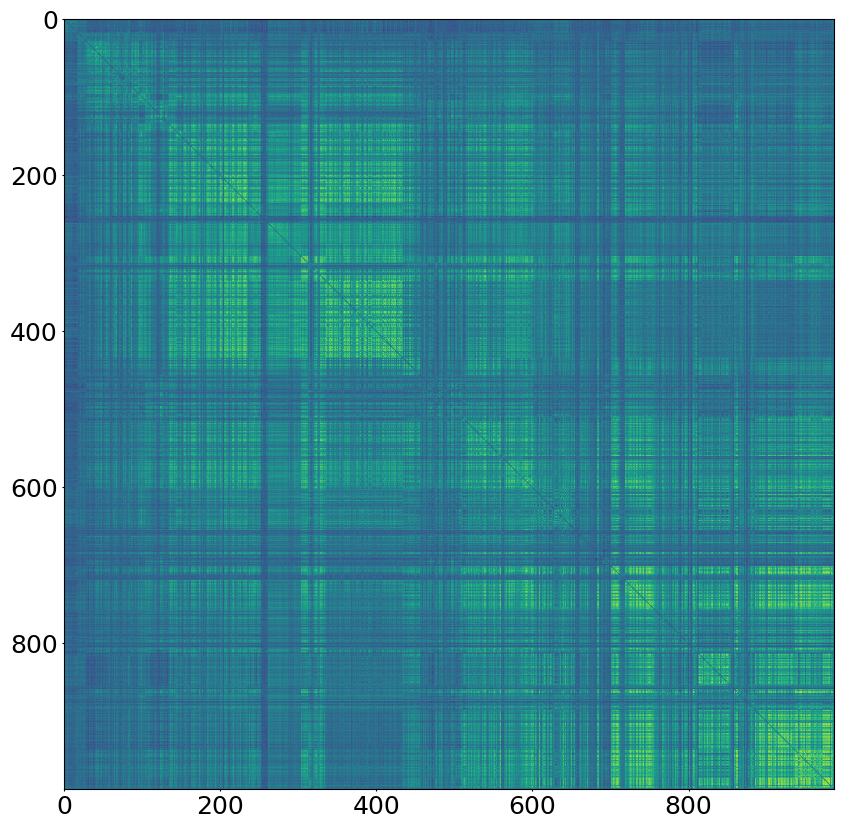

In [270]:
plt.figure(figsize=(10, 10))
plt.imshow(FC_hi_)

In [271]:
map = DiffusionMaps(n_components=10, alpha=0.5, random_state=420)
embedding = map.fit_transform(np.abs(FC_hi_))
gradient1f_hi = embedding[:, 0].flatten()
gradient2f_hi = embedding[:, 1].flatten()

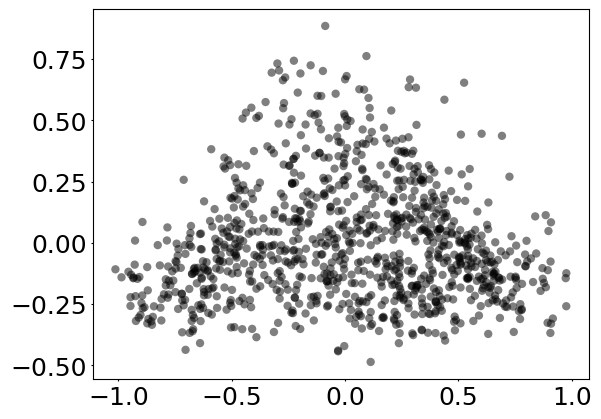

In [272]:
plt.scatter(-gradient1f_hi, gradient2f_hi, color='black', alpha=0.5, edgecolor='None')

In [273]:
e = np.concatenate([excluded_hi, excluded_hi + N_regions])
c = np.delete(region_centroids_hires, e, axis=0)

<function matplotlib.pyplot.savefig(*args, **kwargs)>

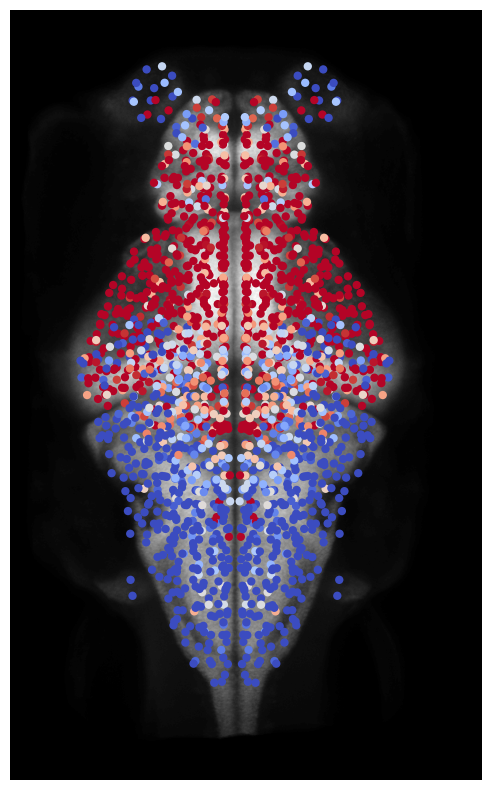

In [274]:
plt.figure(figsize=(10, 10))
plt.imshow(atlas.XYprojection, cmap='gray')
plt.scatter(c[:, 0], c[:, 1], edgecolor='None', c=double(-embedding[:, 0].flatten()), cmap='coolwarm', vmin=-0.25, vmax=0.25)
plt.axis('off')
plt.savefig

In [275]:
np.save('Results/figure6_supp_centroids_hires.npy', c)
np.save('Results/figure6_supp_gradients_hires.npy', embedding)

(-0.5, 973.5, 358.5, -0.5)

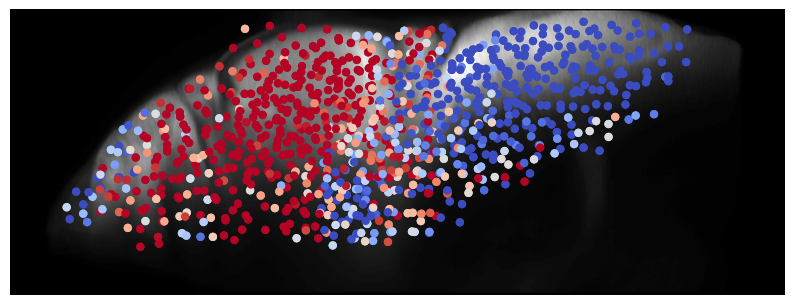

In [276]:
plt.figure(figsize=(10, 10))
plt.imshow(atlas.XZprojection, cmap='gray')
plt.scatter(c[:, 1], c[:, 2], edgecolor='None', c=double(-embedding[:, 0].flatten()), cmap='coolwarm', vmin=-0.25, vmax=0.25)
plt.axis('off')

(-0.5, 596.5, 973.5, -0.5)

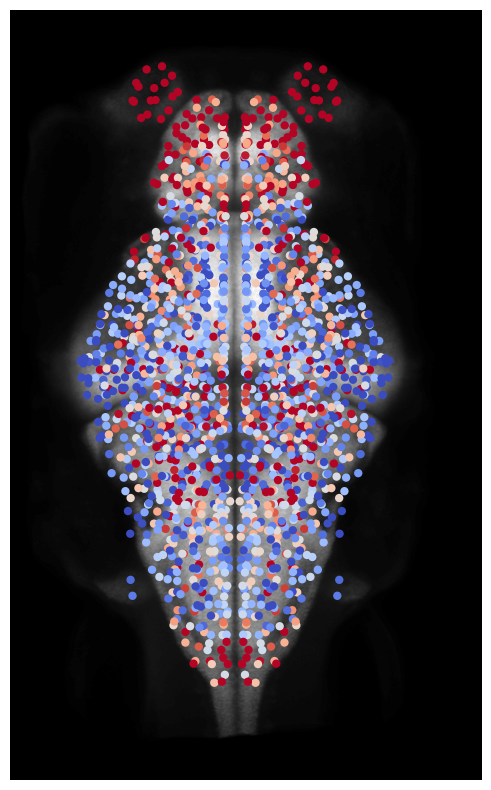

In [277]:
plt.figure(figsize=(10, 10))
plt.imshow(atlas.XYprojection, cmap='gray')
plt.scatter(c[:, 0], c[:, 1], edgecolor='None', c=double(embedding[:, 1].flatten()), cmap='coolwarm', vmin=-0.25, vmax=0.25)
plt.axis('off')

(-0.5, 973.5, 358.5, -0.5)

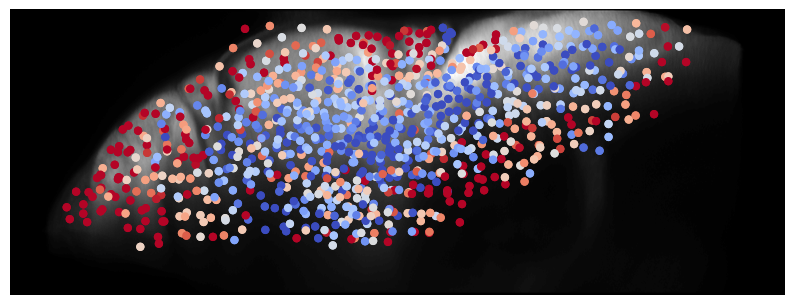

In [278]:
plt.figure(figsize=(10, 10))
plt.imshow(atlas.XZprojection, cmap='gray')
plt.scatter(c[:, 1], c[:, 2], edgecolor='None', c=double(embedding[:, 1].flatten()), cmap='coolwarm', vmin=-0.25, vmax=0.25)
plt.axis('off')

In [279]:
s = np.delete(sensorimotor_index, excluded_hi)

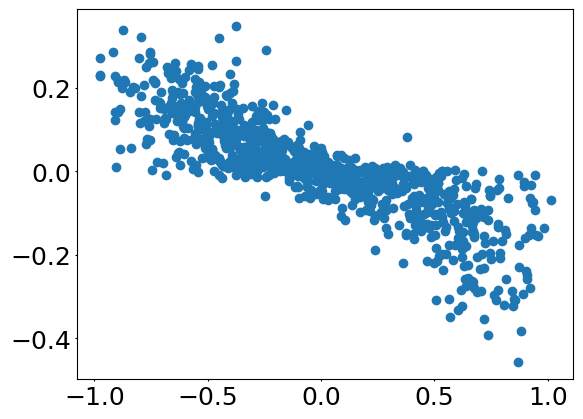

In [280]:
plt.scatter(gradient1f_hi, s)

In [281]:
from scipy.stats import spearmanr
spearmanr(gradient1f_hi, s)

SpearmanrResult(correlation=-0.8861244293944337, pvalue=0.0)

In [282]:
np.save('Results/figure6_FC_hires_stim.npy', FC_hi_)

np.save('centroids_hires.npy', c)
np.save('gradient1.npy', double(gradient1f_hi))
np.save('gradient2.npy', double(gradient2f_hi))